In [ ]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from statsmodels.stats.stattools import durbin_watson
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import scipy.stats as stats

### Montar Dataframe

In [2]:
# Realizar conexão com o GCP
credentials = service_account.Credentials.from_service_account_file("../keys/ml-na-saude-ed1fc3c1a83e.json")
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

In [3]:
# Query para consulta dos dados agrupados por taxa média por quadrimestre
consulta_sql = """
select
	tx.quadrimestre,
	avg(tx.taxa_yll) as taxa_media_yll
from (
	with yll_quadrimestral as (
		select
			case
				when extract(month from y.dt_obito) between 1 and 4 then date(extract(year from y.dt_obito), 4, 30)
				when extract(month from y.dt_obito) between 5 and 8 then date(extract(year from y.dt_obito), 8, 31)
				when extract(month from y.dt_obito) between 9 and 12 then date(extract(year from y.dt_obito), 12, 31)
				end as quadrimestre,
			m.nm_municipio,
			p.populacao,
			sum(y.yll) as soma_yll
		from `ml-na-saude.yll_por_obito.yll` y
		join `ml-na-saude.yll_por_obito.populacao` p on y.cd_mun_res = p.cd_municipio and y.ano_obito = p.ano
		join `ml-na-saude.yll_por_obito.municipio` m on p.cd_municipio = m.cd_municipio
		where p.porte = 'Médio Porte'
		group by 1,2,3
	)
	select
		quadrimestre,
		nm_municipio,
		soma_yll,
		populacao,
		soma_yll / populacao * 1000 as taxa_yll
	from yll_quadrimestral
	group by 1,2,3,4
) tx
group by 1
order by 1
"""

In [4]:
# Ignorar avisos e gerar dataframe
warnings.simplefilter("ignore")
df = client.query(consulta_sql).to_dataframe()

In [5]:
# Copiar dataframe para manipular dados
time_series = df.copy()

In [6]:
# Transformando o quadrimestre em data
time_series['quadrimestre'] = pd.to_datetime(time_series['quadrimestre'])

In [7]:
# Filtrar dados até final de 2019
time_series = time_series[time_series['quadrimestre'] <= '2019-12-31']

In [8]:
time_series

,quadrimestre,taxa_media_yll
0,2010-04-30,6.427726
1,2010-08-31,6.767661
2,2010-12-31,6.111099
3,2011-04-30,6.550037
4,2011-08-31,6.878076
5,2011-12-31,5.804813
6,2012-04-30,6.280719
7,2012-08-31,6.739170
8,2012-12-31,6.049970
9,2013-04-30,6.253954


### Modelo XGBoost

In [9]:
# Separando as variáveis dependentes e independentes
X = time_series.drop(columns=['quadrimestre', 'taxa_media_yll'])
y = time_series['taxa_media_yll']

# Dividindo em treino e teste (usando os últimos 3 anos como teste)
train = time_series.loc[:'2016-12-31']
test = time_series.loc['2017-01-01':]

In [10]:
# Feature Engineering: Sazonalidade com funções trigonométricas para quadrimestres
train['quadrimestre_sin'] = np.sin(2 * np.pi * train['quadrimestre'].dt.month / 12)
train['quadrimestre_cos'] = np.cos(2 * np.pi * train['quadrimestre'].dt.month / 12)
test['quadrimestre_sin'] = np.sin(2 * np.pi * test['quadrimestre'].dt.month / 12)
test['quadrimestre_cos'] = np.cos(2 * np.pi * test['quadrimestre'].dt.month / 12)

In [11]:
# XGBoost com GridSearchCV para ajuste de parâmetros
xgb_model = xgb.XGBRegressor()

In [12]:
# Parâmetros a serem ajustados
param_grid = {
    'n_estimators': [500, 1000, 1500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'subsample': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 2, 3]
}

In [13]:
# Aplicando GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, verbose=1, n_jobs=-1)
grid_search.fit(train[['quadrimestre_sin', 'quadrimestre_cos']], train['taxa_media_yll'])

Fitting 3 folds for each of 729 candidates, totalling 2187 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5], 'min_child_weight': [1, 2, 3],
                         'n_estimators': [500, 1000, 1500],
                         'subsample': [0.6, 0.8, 1.0]},
             verbose=1)

In [14]:
# Melhores parâmetros encontrados
best_params = grid_search.best_params_
print(f"Melhores parâmetros: {best_params}")

Melhores parâmetros: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 1000, 'subsample': 0.6}


In [15]:
# Treinando o modelo com os melhores parâmetros
xgb_best = xgb.XGBRegressor(**best_params)
xgb_best.fit(train[['quadrimestre_sin', 'quadrimestre_cos']], train['taxa_media_yll'])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [16]:
# Fazendo previsões
predictions = xgb_best.predict(test[['quadrimestre_sin', 'quadrimestre_cos']])

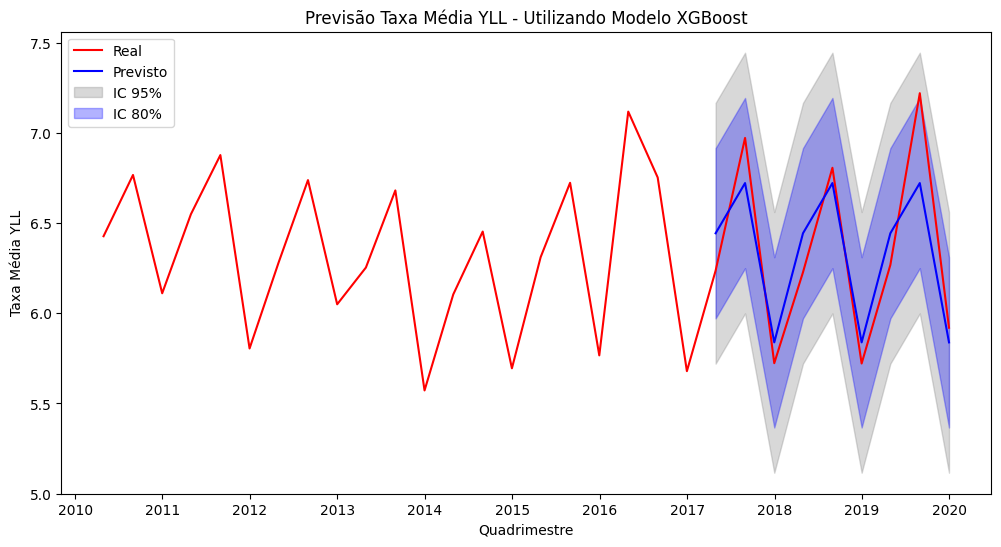

In [17]:
# Plotando os resultados
plt.figure(figsize=(12, 6))

plt.plot(time_series['quadrimestre'], time_series['taxa_media_yll'], color='red', label='Real')
plt.plot(test['quadrimestre'], predictions, color='blue', label='Previsto')

# Intervalo de 95%
plt.fill_between(test['quadrimestre'],
                 predictions - 1.96*np.std(predictions),
                 predictions + 1.96*np.std(predictions),
                 color='gray', alpha=0.3, label='IC 95%')

# Intervalo de 80%
plt.fill_between(test['quadrimestre'],
                 predictions - 1.28*np.std(predictions),
                 predictions + 1.28*np.std(predictions),
                 color='blue', alpha=0.3, label='IC 80%')

plt.title('Previsão Taxa Média YLL - Utilizando Modelo XGBoost')
plt.ylabel('Taxa Média YLL')
plt.xlabel('Quadrimestre')
plt.legend()
# plt.grid(True)
plt.show()

In [18]:
# Calcular o Erro Absoluto Médio (MAE)
mae = mean_absolute_error(test['taxa_media_yll'], predictions)
print(f'MAE: {mae}')

# Calcular o Erro Quadrático Médio (MSE)
mse = mean_squared_error(test['taxa_media_yll'], predictions)
print(f'MSE: {mse}')

# Calcular a Raiz do Erro Quadrático Médio (RMSE)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# Calcular o Erro Percentual Absoluto Médio
mape = mean_absolute_percentage_error(test['taxa_media_yll'], predictions)
print(f'MAPE: {mape}')

# Calcular o erro Theil's U2
def theil_u2(actual, predicted):
    numerator = np.sum((actual - predicted) ** 2)
    denominator = np.sum((actual - np.roll(actual, 1)) ** 2) + np.sum((predicted - np.roll(predicted, 1)) ** 2)
    return np.sqrt(numerator / denominator)

tu = theil_u2(test['taxa_media_yll'], predictions)
print(f'TU: {tu}')

# Teste de Durbin-Watson
residuals = test['taxa_media_yll'] - predictions
dw = durbin_watson(residuals)
print(f'Durbin-Watson: {dw}')

MAE: 0.1941970087896087
MSE: 0.05257534665674802
RMSE: 0.22929314568200249
MAPE: 0.029767627885652896
TU: 0.21173887797034702
Durbin-Watson: 2.362781867949535


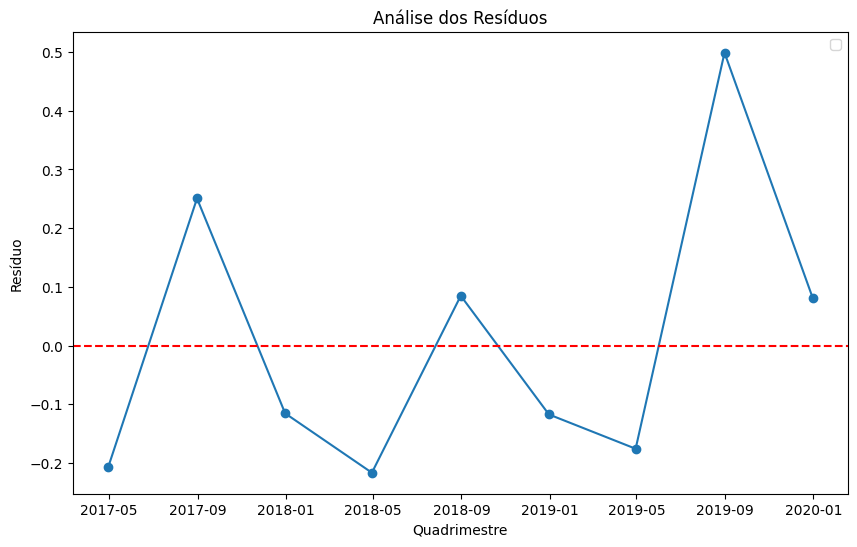

In [19]:
# Analisando resíduos
residuals = test['taxa_media_yll'] - predictions
plt.figure(figsize=(10,6))
plt.plot(test['quadrimestre'], residuals, 'o-')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Análise dos Resíduos')
plt.xlabel('Quadrimestre')
plt.ylabel('Resíduo')
plt.legend()
plt.show()

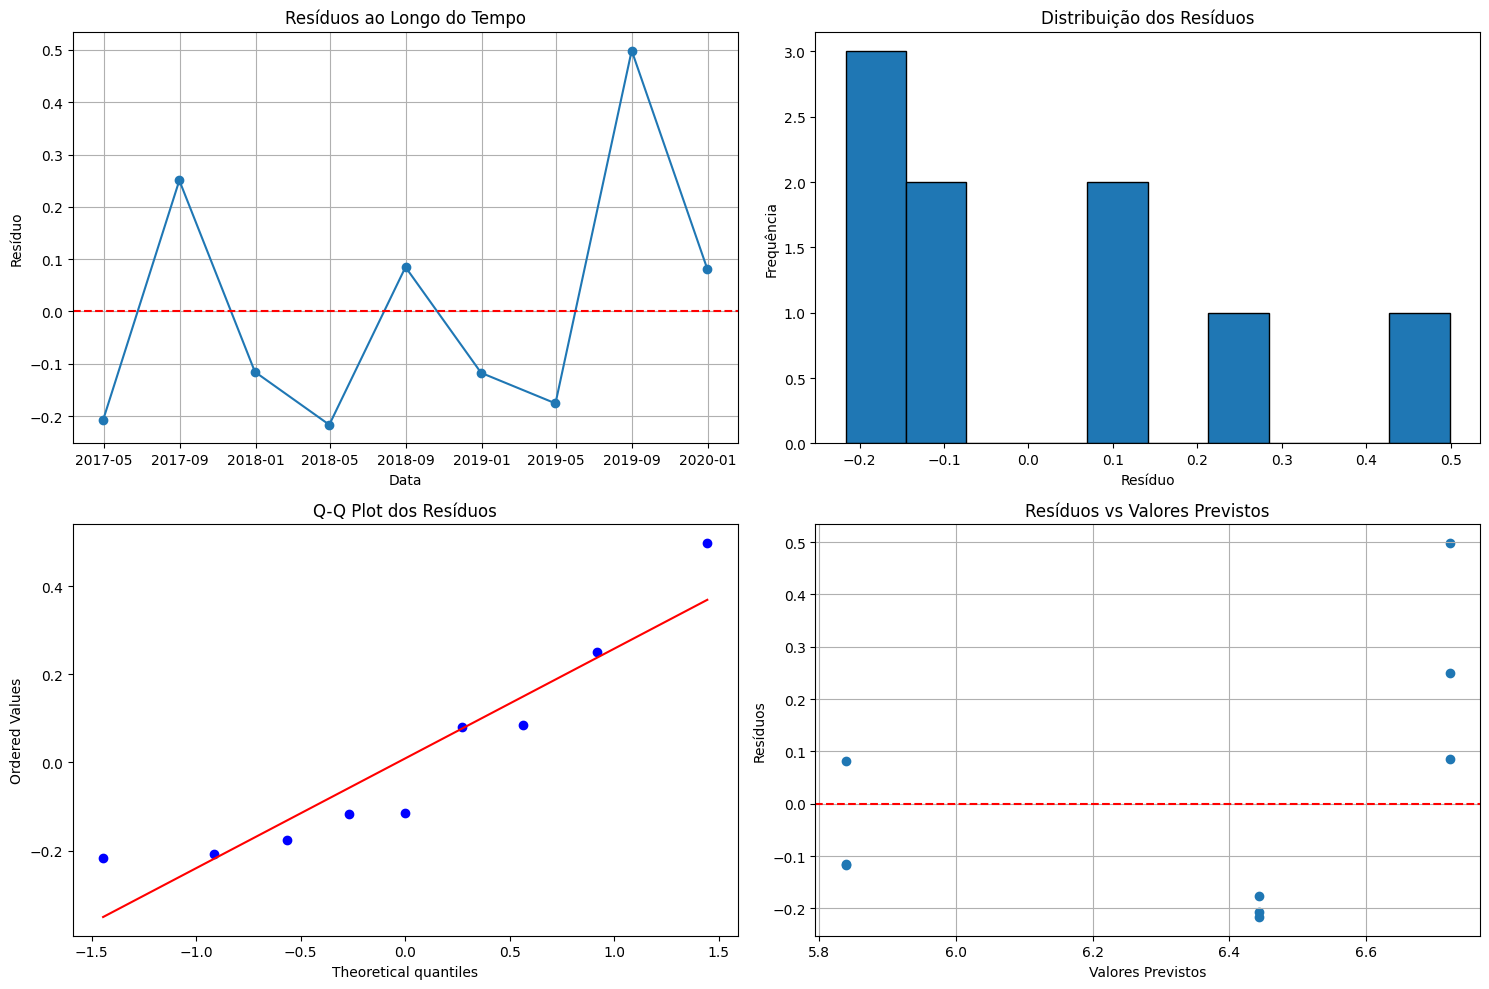


Testes Estatísticos dos Resíduos:
Teste de Normalidade (D'Agostino K²):
p-valor: 0.2414
Resíduos são normais? Sim (α=0.05)

Média dos Resíduos: 0.0093
Desvio Padrão dos Resíduos: 0.2291

Estatística Durbin-Watson: 2.3628
Interpretação do Durbin-Watson:
Não há evidências fortes de autocorrelação


In [ ]:
# Criar figura com subplots para análise completa dos resíduos
fig = plt.figure(figsize=(15, 10))

# 1. Gráfico de Resíduos vs Tempo
plt.subplot(221)
plt.plot(test['quadrimestre'], residuals, 'o-')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Resíduos ao Longo do Tempo')
plt.ylabel('Resíduo')
plt.xlabel('Data')
plt.grid(True)

# 2. Histograma dos Resíduos
plt.subplot(222)
plt.hist(residuals, bins=10, edgecolor='black')
plt.title('Distribuição dos Resíduos')
plt.xlabel('Resíduo')
plt.ylabel('Frequência')

# 3. Q-Q Plot para verificar normalidade
plt.subplot(223)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot dos Resíduos')

# 4. Resíduos vs Valores Previstos
plt.subplot(224)
plt.scatter(predictions, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Resíduos vs Valores Previstos')
plt.xlabel('Valores Previstos')
plt.ylabel('Resíduos')
plt.grid(True)

plt.tight_layout()
plt.show()

# Testes estatísticos
print("\nTestes Estatísticos dos Resíduos:")

# Teste de normalidade
_, p_value_norm = stats.normaltest(residuals)
print(f"Teste de Normalidade (D'Agostino K²):")
print(f"p-valor: {p_value_norm:.4f}")
print(f"Resíduos são normais? {'Sim' if p_value_norm > 0.05 else 'Não'} (α=0.05)")

# Média dos resíduos
mean_residuals = np.mean(residuals)
print(f"\nMédia dos Resíduos: {mean_residuals:.4f}")

# Desvio padrão dos resíduos
std_residuals = np.std(residuals)
print(f"Desvio Padrão dos Resíduos: {std_residuals:.4f}")

# Teste de autocorrelação (Durbin-Watson já calculado anteriormente)
print(f"\nEstatística Durbin-Watson: {dw:.4f}")
print("Interpretação do Durbin-Watson:")
if dw < 1.5:
    print("Possível autocorrelação positiva")
elif dw > 2.5:
    print("Possível autocorrelação negativa")
else:
    print("Não há evidências fortes de autocorrelação")